# Day 6 - Asia

Shaded relief maps of Sri Lanka and Philippines

- Elevation data: GMTED10 mean 7.5 arc-sec (via [USGS](https://topotools.cr.usgs.gov/gmted_viewer/viewer.htm)), merged multiple files using QGIS
- Country shapefile: [Natural Earth](https://www.naturalearthdata.com/downloads/)
- Hillshades: downloaded using [earthpy library](https://earthpy.readthedocs.io/en/latest/index.html)
- Colours come from [palettable](https://jiffyclub.github.io/palettable/)

Full tutorial on shaded relief maps using python by Adam Symington [here](https://towardsdatascience.com/creating-beautiful-topography-maps-with-python-efced5507aa3)

In [163]:
import os
import configparser

import rasterio
import numpy as np
import geopandas as gpd

from shapely.geometry import mapping
from rasterio import mask as msk
import earthpy.spatial as es

# set colors
from matplotlib import colors
import matplotlib.pyplot as plt
from palettable.scientific.diverging import Vik_14
from palettable.cmocean.sequential import Matter_20_r

#set fonts
from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\NotoSansTC-Medium.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\NotoSansTC-Light.otf')

In [3]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

## Process data

In [31]:
# load shapefiles
ne = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(ne, ne)))
phil_shape = countries.loc[countries['ADMIN'] == 'Philippines']
sri_shape = countries.loc[countries['ADMIN'] == 'Sri Lanka']

# import terrain elevation data
phil_file = rasterio.open('gmted_merged.tif')
sri_file = rasterio.open('10S060E_20101117_gmted_mea075.tif')

In [29]:
# function to clip elevation file to country outline
def clip_raster(gdf, img):
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True)
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)],
                                                           crop=True, nodata=(np.amax(clipped_array[0]) + 1))
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range

# get hillshade for topography array
def get_hillshade(topography, azimuth, altitude):
    hillshade = es.hillshade(topography[0], azimuth=azimuth, altitude=altitude)
    hillshade[hillshade == 191.25] = 35
    return hillshade

# amend colour palette so that the highest value = given background colour
def get_colormap(hex_colors, bg_color, value_range):
    listed_colormap = colors.LinearSegmentedColormap.from_list('colorpalette', hex_colors, N=value_range) 
    bg_color = np.array(colors.to_rgba(bg_color))
    newcolors = listed_colormap(np.linspace(0, 1, int(value_range)))
    cmap_new = colors.ListedColormap(np.vstack((newcolors, bg_color)))
    return cmap_new

## Visualise

### Sri Lanka

In [141]:
# get data
topography, value_range = clip_raster(sri_shape, sri_file)
hillshade = get_hillshade(topography, 120, 30)

# colors
hex_colors = ["#FFFFFF","#FFFFFF", "#bc8dad"] + Matter_20_r.hex_colors[4:]
cmap_new = get_colormap(hex_colors, '#F0F0F0', value_range)

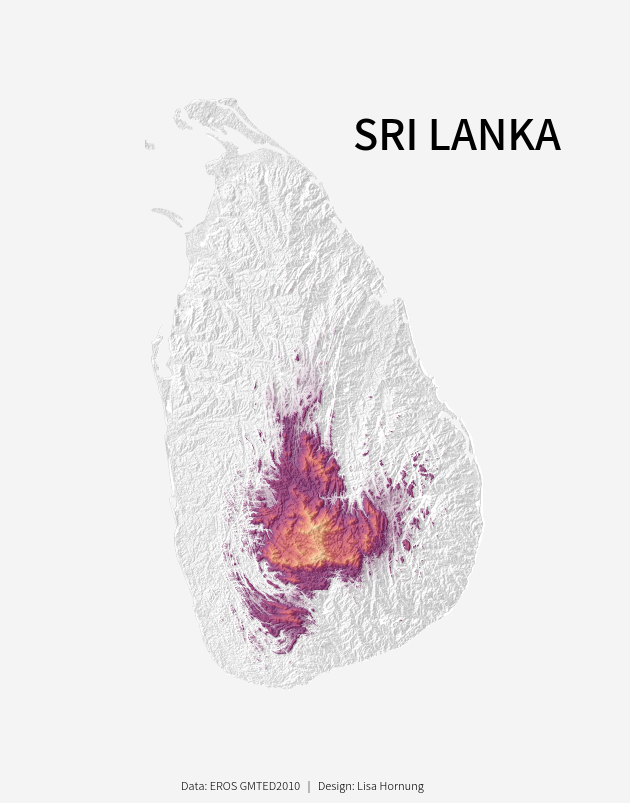

In [142]:
# plot
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor("#F4F4F4")

plt.imshow(topography[0], cmap=cmap_new, interpolation='nearest')
ax.imshow(hillshade, cmap="Greys", alpha=0.3, vmin=60)

# format axis
ax.axis('off')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin=xmax*-0.4, xmax=xmax*1.4)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymax=ymin*-0.15, ymin=ymin*1.15)

#title
#plt.figtext(0.58, 0.65, "Islands of the".upper(), fontproperties=subtitle_font, fontsize=12,  ha="left")
plt.figtext(0.55, 0.74, "Sri Lanka".upper(), fontproperties=title_font, fontsize=30,  ha="left")
plt.figtext(0.5, 0.1, "Data: EROS GMTED2010   |   Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="center")

plt.savefig("shaded-relief-sri-lanka.png", bbox_inches='tight', pad_inches=1.5, facecolor="#F4F4F4")
plt.show()

### Philippines

In [160]:
# get data
topography, value_range = clip_raster(phil_shape, phil_file)
hillshade = get_hillshade(topography, 90, 30)

# colors
hex_colors = Vik_14.hex_colors[:]
cmap_new = get_colormap(hex_colors, '#F0F0F0', value_range)
hex_colors = ["#FFFFFF","#eee2ea", "#bc8dad"] + Matter_20_r.hex_colors[3:]
cmap_new = get_colormap(hex_colors, '#F0F0F0', value_range)

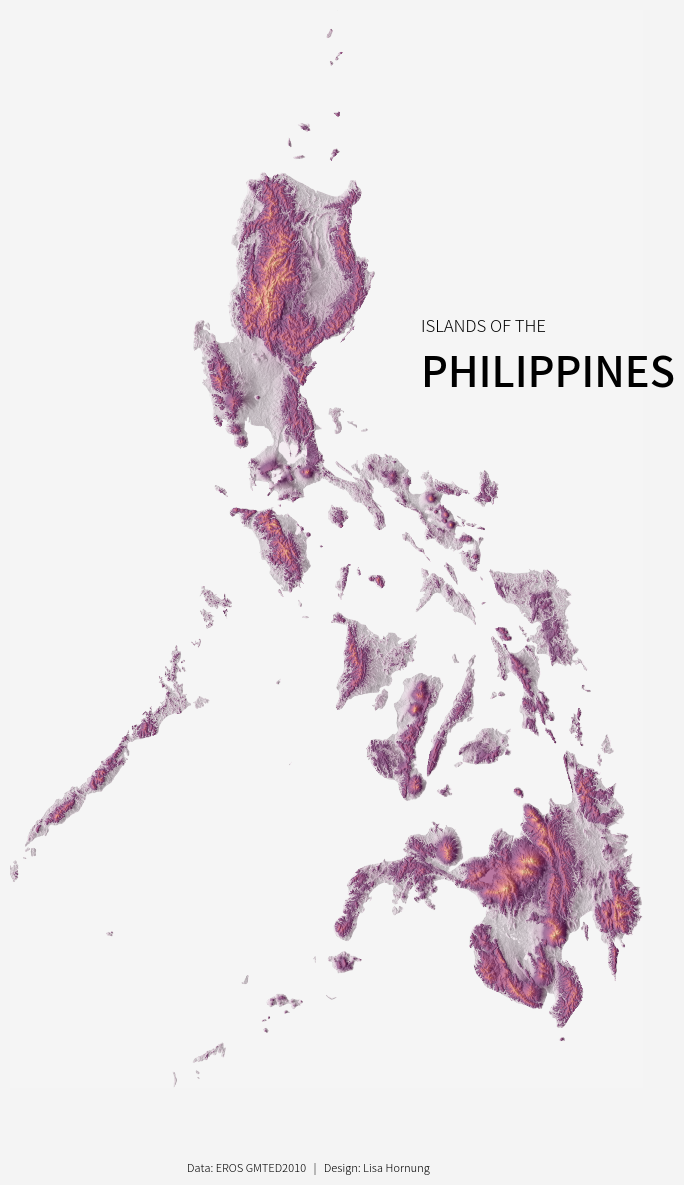

In [162]:
# plot
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor("#F4F4F4")

plt.imshow(topography[0], cmap=cmap_new, interpolation='nearest')
ax.imshow(hillshade, cmap="Greys", alpha=0.4, vmin=50)
ax.axis('off')

#title
plt.figtext(0.58, 0.65, "Islands of the".upper(), fontproperties=subtitle_font, fontsize=12,  ha="left")
plt.figtext(0.58, 0.61, "Philippines".upper(), fontproperties=title_font, fontsize=30,  ha="left")
plt.figtext(0.5, 0.05, "Data: EROS GMTED2010   |   Design: Lisa Hornung", fontproperties=subtitle_font, fontsize=8, ha="center")

plt.savefig("shaded-relief-philippines-v2.png", bbox_inches='tight', pad_inches=1.5, facecolor="#F4F4F4")
plt.show()

## Playground

In [122]:
# played around with quite a few colour palettes before settling on one
from palettable.cartocolors.sequential import Magenta_7_r, PurpOr_5, Sunset_5_r, Teal_7, agGrnYl_5_r
from palettable.cartocolors.diverging import  Earth_7_r, TealRose_7, Temps_7
from palettable.cmocean.sequential import Deep_14, Matter_20_r, Dense_20
from palettable.matplotlib import Magma_20_r
from palettable.scientific.sequential import Buda_20_r, Nuuk_12, Tokyo_14
from palettable.scientific.diverging import Broc_14_r, Vik_14

In [98]:
option1 = ["#FFFFFF","#FFFFFF", "#bc8dad"] + Matter_20_r.hex_colors[4:]